The Augmented Lagrangian
$$
L_{\sigma}(c,b,u;\lambda)=\frac{1}{2}c^{\top}Kc+C\|u_+\|_0+\frac{\sigma}{2}\|u-\big({\mathbf 1}-{\rm diag}(y)K c-b*y-\frac{\boldsymbol{\lambda}}{\sigma}\big)\|^2-\frac{\|\boldsymbol{\lambda}\|^2}{2\sigma}.
$$

In [125]:
# coding=utf-8
#L01 Proximal Operator Prox_{gamma C||(.)_+||}(eta)=argmin_{v} C||(v)_+||_0+1/(2gamma)||v-eta||^2
def Prox(eta,threshold):
    eta[np.where(np.logical_and(eta>0,eta<=threshold))] = 0  #threshold=np.sqrt(2*gamma*C)
    return eta

In [126]:
#Packages
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from scipy import linalg
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import pairwise_kernels  
import time

In [127]:
#Dataset: Double Circles
#https://scikit-learn.org/0.19/modules/generated/sklearn.datasets.make_circles.html
from sklearn.datasets import  make_circles
random.seed(6)
X,Y=make_circles(n_samples=1500,noise=0.1,factor=0.1,random_state=3)

In [128]:
from sklearn import preprocessing 
Y[np.where(Y==0)]=-1  #Transform label 0，1 to label -1，1
Standardscaler = preprocessing.StandardScaler() 
#https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler
X = Standardscaler.fit_transform(X)

# #Label noise  ratio r=0%(0)，1%（10）,5%（50）,10%（100）
# index_labelnoise=random.sample(range(len(Y)),100) # 2*r%*500 percent of label noise
# #print(index_labelnoise)
# Y[index_labelnoise]=-Y[index_labelnoise]

X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.4,random_state=33)
print('X train shape',X_train.shape)
print('X test shape',X_test.shape)

X train shape (900, 2)
X test shape (600, 2)


L01KSVM:

In [129]:
#L01KSVMTrain
start = time.time()
K = pairwise_kernels(X_train, Y=None, metric='rbf')  # ‘linear’, ‘poly’, ‘rbf’, ‘laplacian
y = y_train
m=np.shape(X_train)[0]

    
#Initialization
c = np.zeros(m)               #coefficients
b=0                           #b=1,-1 bias
u = np.random.random(m)       #loss
Lambda = np.random.random(m)  #Multipliers
max_iter=2000                  #Maximum iteration
beta=np.zeros(4)              #KKT error
tol=1e-3                      #KKT tolerance level 

#Best parameters obtained by Gridseach
C=8
sigma=1
iota=1          #learning_rate=iota*sigma
# acc=np.zeros(max_iter)

for i in range(max_iter): 
          
    #updating u
    u_k=np.ones(m)- np.multiply(y,np.dot(K,c))-b*y 
    eta=u_k- Lambda/sigma # eta=np.ones(m)- np.multiply(y,np.dot(K,c))-b*y #np.dot(np.dot(y_diag,K),c)=np.multiply(y,np.dot(K,c))    
    u = Prox(eta,2*C/sigma)   
            
    #updating c   
    xi = np.ones(m)-u- b*y-Lambda/sigma
    c = linalg.solve(K+np.eye(m)/sigma,np.multiply(y,xi))   #np.dot(y_diag,xi)=np.multiply(y,xi)
        
    #updating b
    r = np.ones(m)- u- np.multiply(y,np.dot(K,c))-Lambda/sigma
    b = np.dot(y.T,r)/m
    
    #updating Lambda 
    w = u + np.multiply(y,np.dot(K,c)) + b*y - np.ones(m) 
    index = np.where(u==0)[0]
    index_c= np.nonzero(u)[0]
    Lambda[index]=Lambda[index]+iota*sigma*w[index]      
    Lambda[index_c]=0
    
#     #Accuracy stopping rule
#     acc[i]=accuracy_score(np.sign(-np.dot(K,np.multiply(Lambda,y)) + b),y_train)
#     if np.logical_and(i>5,acc[i]>0.8):
#         if np.std(acc[i-3:i],ddof=1)<1e-3:
#             print('Accuracy is stable when i=',i+1)
#             break
    
    #proximal stationary point stopping rule
    beta[0]=np.linalg.norm(c+np.multiply(y,Lambda),2)/(1+np.linalg.norm(c,2))#c related to lambda；
    beta[1]=(np.abs(np.dot(y.T,Lambda)))/m  
    beta[2]=np.linalg.norm(w,2)/np.sqrt(m)  
    beta[3]=np.linalg.norm(u_k-u,2)/(1+np.linalg.norm(u,2)) 
    #print('KKT error beta',beta.T)
    if  np.amax(beta)<tol: 
        print('KKT condition (tolerance level=1e-4) is satisfied with iteration i:=',i+1)
        break  
        
end = time.time()
Iter = i+1
print('Program time of L01KSVM is:%ss'%(str(end-start)))

KKT condition (tolerance level=1e-4) is satisfied with iteration i:= 655
Program time of L01KSVM is:15.650926351547241s


In [130]:
#Output Solutions of L01KSVM
#print('solution b',b)
#print('solution c tranpose',c[np.nonzero(u)[0]].T)
#print('solution u tranpose',u[np.nonzero(u)[0]].T)
#print('solution Lambda:\n',Lambda[np.nonzero(Lambda)[0]].T)
#print('Lambda:\n',Lambda.shape)

In [131]:
#L01KSVM Accuracy 
print('Train Accuracy:\n', accuracy_score(np.sign(-np.dot(K,np.multiply(Lambda,y)) + b),y_train))
K_test = pairwise_kernels(X_test,X_train, metric='rbf') 
print('Test Accuracy:\n', accuracy_score(np.sign(-np.dot(K_test,np.multiply(Lambda,y) ) + b),y_test))

Train Accuracy:
 1.0
Test Accuracy:
 1.0


Gaussian Kernel SVM with the Hinge Loss: $\ell_1$-KSVM

In [132]:
#Dual SVM Algorithm: Stochastic Gradient Ascent
#Reference: Mohammed J. Zaki, Wagner Meira  Jr., Data Mining and Machine Learning Fundamental Concepts and Algorithms (2nd, 2020),p.540
#kernel matrix, hinge loss
C1=8
start1 = time.time()
K1 = pairwise_kernels(X_train, Y=None, metric='rbf')  # ‘linear’, ‘poly’, ‘rbf’, ‘laplacian
Ktilde=K1+1  #augmented kernel matrix
m=np.shape(X_train)[0]
a=np.random.random(m)
for k in range(100):
    ak=a.copy()
    for i in range(m):
        ak[i]=ak[i]+(1-y_train[i]*np.dot(np.multiply(ak,y_train),Ktilde[i,:]))/(K1[i,i]+1)
        if ak[i]<0:
            ak[i]=0
        elif ak[i]>C1:
            ak[i]=C1
        else:
            ak[i]=ak[i]
#     print(np.linalg.norm(ak-a,2))
    if np.linalg.norm(ak-a,2)<0.12:
        print('The stop rule is satisfied with k=',k)
        break
    else:
        a=ak.copy()

end1 = time.time()
Iter1 = k+1
print('Train Accuracy:\n', accuracy_score(np.sign(np.dot(Ktilde,np.multiply(a,y_train))),y_train))
K_test1 = pairwise_kernels(X_test,X_train, metric='rbf') +1
print('Test Accuracy:\n', accuracy_score(np.sign(np.dot(K_test1,np.multiply(a,y_train) )),y_test))

The stop rule is satisfied with k= 27
Train Accuracy:
 1.0
Test Accuracy:
 1.0


Gaussian Kernel SVM with Squared Hinge Loss: $\ell_2$-KSVM

In [133]:
#Standard Gaussian Kernel SVM with Squared Hinge Loss
#Best parameter obtained by Gridsearch
C2 = 4
start2 = time.time()
#if gamma='scale' (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,
clf=SVC(C=C2,kernel='rbf').fit(X_train,y_train)  #default='squared_hinge'
end2 = time.time()
#print('Indices of support vectors for HingeKSVM:\n',clf.support_)
support_vectors =clf.support_vectors_  #Support vectors.
#Decision_function = np.dot(X, clf.coef_[0]) + clf.intercept_[0]
decision_function = clf.decision_function(X_train)
support_vector_indices_canonical = np.where(np.abs(decision_function) <= 1 + 1e-15)[0]
#print('Total number of SV on canonical hyperplane:',support_vector_indices_canonical.shape[0])

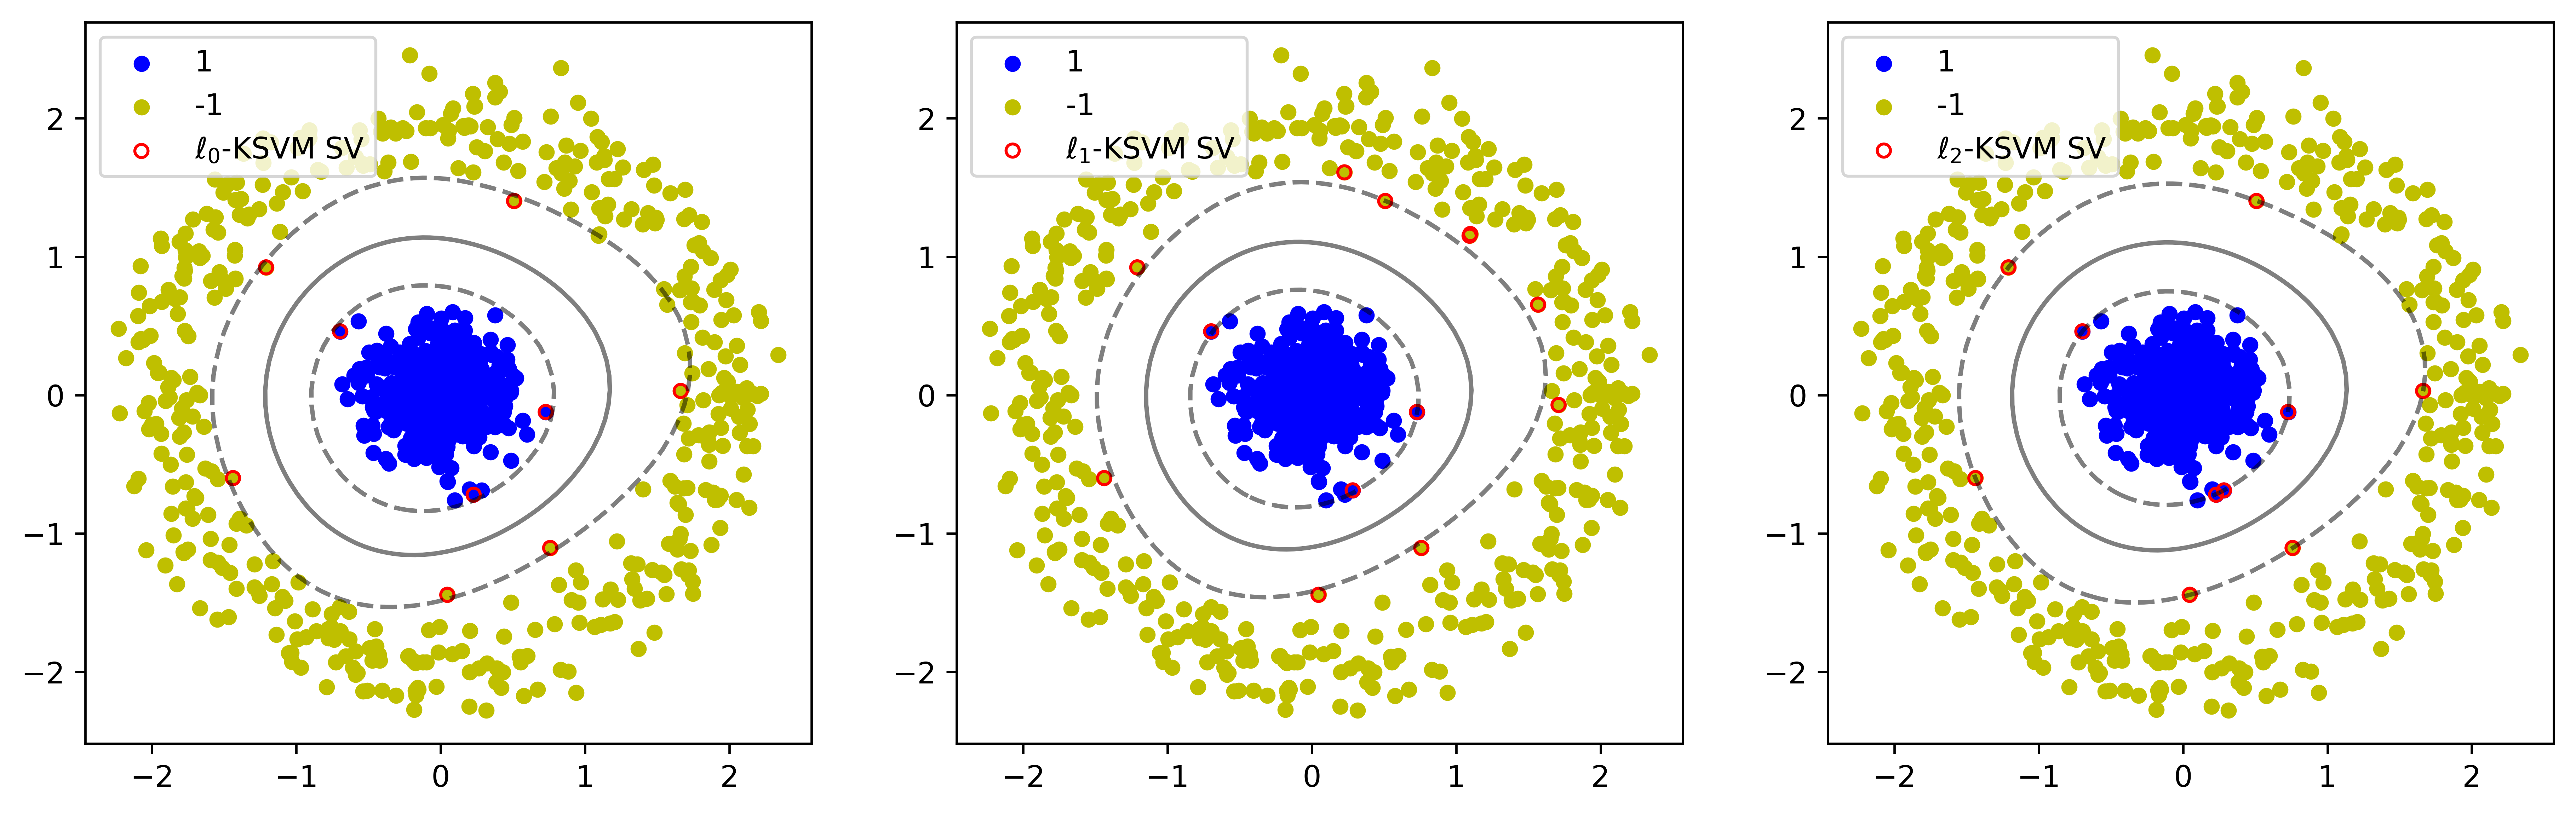

In [134]:
# ##L01KSVM:plot the decision function 
plt.rcParams['figure.figsize'] = (15.0, 4.5) 
plt.subplot(1,3,1)
#plt.rcParams['figure.dpi'] = 200 #分辨率

plt.rcParams['font.size'] = '10'
plt.rcParams['savefig.dpi'] = 600
#plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=10, cmap=plt.cm.Paired)
idx_1 = np.where(y_train==1)
p1 = plt.scatter(X_train[idx_1,0], X_train[idx_1,1], marker = 'o', color = 'b', label='1', s = 20)
idx_2 = np.where(y_train==-1)
p2 = plt.scatter(X_train[idx_2,0], X_train[idx_2,1], marker = 'o', color = 'y', label='-1', s = 20)

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 100), np.linspace(ylim[0], ylim[1], 50))
K_classifier = pairwise_kernels(np.c_[xx.ravel(), yy.ravel()],X_train, metric='rbf') 
Y_classifiervalue=-np.dot(K_classifier,np.multiply(Lambda,y) ) + b  
Z=Y_classifiervalue.reshape(xx.shape)

plt.contour(xx,yy,Z,colors='k',levels=[-1, 0, 1], alpha=0.5,linestyles=['--', '-', '--'])
index_sv=np.nonzero(Lambda)[0] 
sv_L01Loss = X_train[index_sv]  #support vectors for L01KSVM
plt.scatter(sv_L01Loss[:, 0],sv_L01Loss[:, 1],s=20,linewidth=1,facecolors='none',edgecolors='r',label='$\ell_0$-KSVM SV')
plt.legend(loc = 'upper left')
#plt.title('L01KSVM',fontsize=10)
#plt.savefig('L01KSVM__DoubleMoons.png', bbox_inches='tight')


# ##L1KSVM:plot the decision function 
plt.subplot(1,3,2)
plt.rcParams['font.size'] = '10'
plt.rcParams['savefig.dpi'] = 600
#plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=10, cmap=plt.cm.Paired)
idx_1 = np.where(y_train==1)
p1 = plt.scatter(X_train[idx_1,0], X_train[idx_1,1], marker = 'o', color = 'b', label='1', s = 20)
idx_2 = np.where(y_train==-1)
p2 = plt.scatter(X_train[idx_2,0], X_train[idx_2,1], marker = 'o', color = 'y', label='-1', s = 20)

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 100), np.linspace(ylim[0], ylim[1], 50))
K_classifier1 = pairwise_kernels(np.c_[xx.ravel(), yy.ravel()],X_train, metric='rbf') +1
Y_classifiervalue1=np.dot(K_classifier1,np.multiply(a,y_train) )   
Z=Y_classifiervalue1.reshape(xx.shape)

plt.contour(xx,yy,Z,colors='k',levels=[-1, 0, 1], alpha=0.5,linestyles=['--', '-', '--'])
index_sv1=np.nonzero(a)[0] 
sv_L1Loss = X_train[index_sv1]  #support vectors for L01KSVM
plt.scatter(sv_L1Loss[:, 0],sv_L1Loss[:, 1],s=20,linewidth=1,facecolors='none',edgecolors='r',label='$\ell_1$-KSVM SV')
plt.legend(loc = 'upper left')


# #HingeKSVM:plot the decision function
plt.subplot(1,3,3)
plt.rcParams['figure.dpi'] = 600 #分辨率
plt.rcParams['font.size'] = '10'
#plt.rcParams['figure.figsize'] = (8.0, 4.0) 
#plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=10, cmap=plt.cm.Paired)
idx_1 = np.where(y_train==1)
p1 = plt.scatter(X_train[idx_1,0], X_train[idx_1,1], marker = 'o', color = 'b', label='1', s = 20)
idx_2 = np.where(y_train==-1)
p2 = plt.scatter(X_train[idx_2,0], X_train[idx_2,1], marker = 'o', color = 'y', label='-1', s = 20)

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 100), np.linspace(ylim[0], ylim[1], 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
plt.contour(xx,yy,Z,colors='k',levels=[-1, 0, 1], alpha=0.5,linestyles=['--', '-', '--'])
plt.scatter(support_vectors[:, 0],support_vectors[:, 1],s=20,linewidth=1,facecolors='none',edgecolors='r',label='$\ell_2$-KSVM SV')
plt.legend(loc = 'upper left')
#plt.title('SquaredHingeKSVM',fontsize=10)
plt.savefig('KSVM_DoubleCircleLabel10_500.png', bbox_inches='tight')

In [135]:
#Summary
#L01KSVM 
print({'C':C,'sigma':sigma,'iota':iota,'C1':C1,'C2':C2})
print('Threshold',np.sqrt((2*C)/sigma))

#dataset
print('Number of Training Data',m)
print('Number of Testing Data',y_test.shape[0])

#Accuracy
print('Train Accuracy of L01KSVM:',accuracy_score(np.sign(-np.dot(K,np.multiply(Lambda,y)) + b),y_train))
print('Test Accuracy of  L01KSVM:',accuracy_score(np.sign(-np.dot(K_test,np.multiply(Lambda,y) ) + b),y_test))
print('Train Accuracy of L1KSVM:',accuracy_score(np.sign(np.dot(Ktilde,np.multiply(a,y_train))),y_train))
print('Test Accuracy of  L1KSVM:',accuracy_score(np.sign(np.dot(K_test1,np.multiply(a,y_train) )),y_test))
print('Train accuracy of HingeKSVM:',clf.score(X_train,y_train))
print('Test accuracy of HingeKSVM:',clf.score(X_test,y_test))

# Iteration
print('Iteration of L01KSVM:',Iter)
print('Iteration of L1KSVM:',Iter1)

#Number of Support Vectors
print('Number of support vectors for L01KSVM',len(index_sv))  
print('Number of support vectors for L1KSVM',len(index_sv1))  
print('Number of support vectors for HingeKSVM:',np.sum(clf.n_support_))

#Indices
print('Indices of support vectors for L01KSVM:\n',index_sv)
#print('Indices of support vectors for HingeKSVM:\n',clf.support_)

#Dual Coefficients
print('Lambda with nonzero elements for L01KSVM:\n',Lambda[np.nonzero(Lambda)])
print('Dual coefficients of the support vector in the decision function:\n',clf.dual_coef_)

#Computation Time
print('Computation Time for L01SVM',end-start)
print('Computation Time for L1SVM',end1-start1)
print('Computation Time for HingeKSVM',end2-start2)

{'C': 8, 'sigma': 1, 'iota': 1, 'C1': 8, 'C2': 4}
Threshold 4.0
Number of Training Data 900
Number of Testing Data 600
Train Accuracy of L01KSVM: 1.0
Test Accuracy of  L01KSVM: 1.0
Train Accuracy of L1KSVM: 1.0
Test Accuracy of  L1KSVM: 1.0
Train accuracy of HingeKSVM: 1.0
Test accuracy of HingeKSVM: 1.0
Iteration of L01KSVM: 655
Iteration of L1KSVM: 28
Number of support vectors for L01KSVM 9
Number of support vectors for L1KSVM 13
Number of support vectors for HingeKSVM: 10
Indices of support vectors for L01KSVM:
 [118 207 212 224 301 372 537 690 761]
Lambda with nonzero elements for L01KSVM:
 [-0.88086085 -0.30196298 -2.71360654 -1.26708903 -4.65415685 -3.16380663
 -1.27084755 -4.04617358 -0.88599336]
Dual coefficients of the support vector in the decision function:
 [[-0.27861205 -2.66061224 -1.17214121 -3.11491468 -1.23030654 -0.86652225
   0.49518034  0.85670596  4.          3.97122269]]
Computation Time for L01SVM 15.650926351547241
Computation Time for L1SVM 0.26386117935180664


Numerical Results

In [136]:
#m=500,r=0%,  
# {'C': 8, 'sigma': 1, 'iota': 1, 'C1': 8, 'C2': 4}
# Threshold 4.0
# Number of Training Data 300
# Number of Testing Data 200
# Train Accuracy of L01KSVM: 1.0
# Test Accuracy of  L01KSVM: 1.0
# Train Accuracy of L1KSVM: 1.0
# Test Accuracy of  L1KSVM: 1.0
# Train accuracy of HingeKSVM: 1.0
# Test accuracy of HingeKSVM: 1.0
# Iteration of L01KSVM: 272
# Iteration of L1KSVM: 37
# Number of support vectors for L01KSVM 11
# Number of support vectors for L1KSVM 19
# Number of support vectors for HingeKSVM: 11
# Indices of support vectors for L01KSVM:
#  [ 20  54  63  86 129 142 153 165 247 254 259]
# Lambda with nonzero elements for L01KSVM:
#  [-0.11608115 -0.31848367 -0.4520818  -3.57813652 -0.86025816 -2.8415647
#  -1.45660342 -1.73833099 -0.11246873 -0.15167301 -0.39654507]
# Dual coefficients of the support vector in the decision function:
#  [[-0.10299431 -0.303769   -0.43790076 -2.82495639 -1.72108298 -0.14720447
#   -0.39699426  3.55343749  0.8376952   1.44271734  0.10105213]]
# Computation Time for L01SVM 0.29227280616760254
# Computation Time for L1SVM 0.0009965896606445312
# Computation Time for HingeKSVM 0.0009968280792236328

In [137]:
#m=1000, r=0%,
# {'C': 8, 'sigma': 1, 'iota': 1, 'C1': 8, 'C2': 4}
# Threshold 4.0
# Number of Training Data 600
# Number of Testing Data 400
# Train Accuracy of L01KSVM: 1.0
# Test Accuracy of  L01KSVM: 1.0
# Train Accuracy of L1KSVM: 1.0
# Test Accuracy of  L1KSVM: 1.0
# Train accuracy of HingeKSVM: 1.0
# Test accuracy of HingeKSVM: 1.0
# Iteration of L01KSVM: 498
# Iteration of L1KSVM: 48
# Number of support vectors for L01KSVM 10
# Number of support vectors for L1KSVM 12
# Number of support vectors for HingeKSVM: 10
# Indices of support vectors for L01KSVM:
#  [ 82  95 107 149 155 239 244 291 302 507]
# Lambda with nonzero elements for L01KSVM:
#  [-3.07981461 -0.54170972 -1.20675513 -2.64475405 -2.6167285  -2.01664603
#  -0.62658542 -0.53516099 -1.46253704 -2.02019016]
# Dual coefficients of the support vector in the decision function:
#  [[-0.52402883 -1.18204213 -2.57337445 -0.51078975 -1.42541313 -2.00375937
#    3.02992473  2.62080497  1.9863012   0.58237677]]
# Computation Time for L01SVM 4.779572248458862
# Computation Time for L1SVM 0.27941298484802246
# Computation Time for HingeKSVM 0.001995086669921875

In [138]:
# m=1500, r=0%
# {'C': 8, 'sigma': 1, 'iota': 1, 'C1': 8, 'C2': 4}
# Threshold 4.0
# Number of Training Data 900
# Number of Testing Data 600
# Train Accuracy of L01KSVM: 1.0
# Test Accuracy of  L01KSVM: 1.0
# Train Accuracy of L1KSVM: 1.0
# Test Accuracy of  L1KSVM: 1.0
# Train accuracy of HingeKSVM: 1.0
# Test accuracy of HingeKSVM: 1.0
# Iteration of L01KSVM: 655
# Iteration of L1KSVM: 28
# Number of support vectors for L01KSVM 9
# Number of support vectors for L1KSVM 13
# Number of support vectors for HingeKSVM: 10
# Indices of support vectors for L01KSVM:
#  [118 207 212 224 301 372 537 690 761]
# Lambda with nonzero elements for L01KSVM:
#  [-0.88086085 -0.30196298 -2.71360654 -1.26708903 -4.65415685 -3.16380663
#  -1.27084755 -4.04617358 -0.88599336]
# Dual coefficients of the support vector in the decision function:
#  [[-0.27861205 -2.66061224 -1.17214121 -3.11491468 -1.23030654 -0.86652225
#    0.49518034  0.85670596  4.          3.97122269]]
# Computation Time for L01SVM 15.650926351547241
# Computation Time for L1SVM 0.26386117935180664
# Computation Time for HingeKSVM 0.0009989738464355469

In [139]:
#m=500,r=1%
# {'C': 1, 'sigma': 1, 'iota': 1, 'C1': 8, 'C2': 4}
# Threshold 1.4142135623730951
# Program time of L01KSVM is:2.2808706760406494s
# Number of Training Data 300
# Number of Testing Data 200
# Train Accuracy of L01KSVM: 0.9833333333333333
# Test Accuracy of  L01KSVM: 0.975
# Train Accuracy of L1KSVM: 0.9833333333333333
# Test Accuracy of  L1KSVM: 0.945
# Train accuracy of HingeKSVM: 0.9833333333333333
# Test accuracy of HingeKSVM: 0.97
# Iteration of L01KSVM: 2000
# Iteration of L1KSVM: 83
# Number of support vectors for L01KSVM 16
# Number of support vectors for L1KSVM 29
# Number of support vectors for HingeKSVM: 20
# Indices of support vectors for L01KSVM:
#  [ 20  54  63  86 129 143 153 165 217 223 242 247 254 258 259 289]
# Lambda with nonzero elements for L01KSVM:
#  [-0.09052532 -0.68441952 -0.62430493 -0.9313007  -1.60103323 -1.55174019
#  -0.11757076 -1.59451886 -0.16859187 -0.16896694  0.01770886 -0.45882212
#  -0.28568951 -0.47114152 -0.11683126 -1.64811069]
# Dual coefficients of the support vector in the decision function:
#  [[-0.54719524 -1.27241925 -2.79209303 -2.12710431 -4.         -4.
#   -3.92361091 -0.20385174 -2.92482133 -0.20154979 -0.3203877  -4.
#    0.58859807  4.          4.          4.          2.72574831  4.
#    4.          2.99868693]]
# Computation Time for L01SVM 2.2808706760406494
# Computation Time for L1SVM 0.22240424156188965
# Computation Time for HingeKSVM 0.0009965896606445312

In [140]:
# #m=500,r=5%
# {'C': 0.5, 'sigma': 1, 'iota': 1, 'C1': 8, 'C2': 4}
# Threshold 1.0
# Program time of L01KSVM is:2.2075231075286865s
# Number of Training Data 300
# Number of Testing Data 200
# Train Accuracy of L01KSVM: 0.9066666666666666
# Test Accuracy of  L01KSVM: 0.89
# Train Accuracy of L1KSVM: 0.91
# Test Accuracy of  L1KSVM: 0.885
# Train accuracy of HingeKSVM: 0.9066666666666666
# Test accuracy of HingeKSVM: 0.89
# Iteration of L01KSVM: 2000
# Iteration of L1KSVM: 100
# Number of support vectors for L01KSVM 19
# Number of support vectors for L1KSVM 94
# Number of support vectors for HingeKSVM: 73
# Indices of support vectors for L01KSVM:
#  [ 20  22  33  54 127 129 130 143 162 169 176 219 223 241 247 254 257 258
#  259]
# Lambda with nonzero elements for L01KSVM:
#  [-0.08378341  0.00715796 -0.03786784 -0.22906281 -0.47295727 -0.74708074
#  -0.69731899 -0.18237636 -0.10986212 -0.50122675 -0.4186572  -0.42847388
#  -0.16580534 -0.29981889 -0.89224472 -0.59488004 -0.56360762 -0.72082232
#  -0.41700744]
# Dual coefficients of the support vector in the decision function:
#  [[-4.         -1.28058899 -4.         -0.9852897  -4.         -2.63511739
#   -0.53482602 -4.         -4.         -4.         -3.53303154 -4.
#   -4.         -2.71507372 -4.         -4.         -4.         -4.
#   -1.05291935 -4.         -4.         -3.07308166 -0.87061992 -0.17594876
#   -4.         -2.94421777 -4.         -3.98551168 -1.02115987 -4.
#   -2.17490517 -4.         -4.         -4.         -4.         -4.
#   -0.84518437 -0.5073909  -4.          4.          4.          4.
#    4.          4.          4.          4.          4.          4.
#    1.42504831  4.          4.          4.          4.          0.26876976
#    4.          4.          4.          4.          4.          4.
#    1.11291438  4.          4.          4.          4.          4.
#    4.          4.          4.          1.43372147  4.          0.09441287
#    4.        ]]
# Computation Time for L01SVM 2.2075231075286865
# Computation Time for L1SVM 0.21477198600769043
# Computation Time for HingeKSVM 0.0019655227661132812

In [141]:
#m=500,r=10%
# {'C': 0.5, 'sigma': 1, 'iota': 1, 'C1': 8, 'C2': 4}
# Threshold 1.0
# Program time of L01KSVM is:2.380631446838379s
# Number of Training Data 300
# Number of Testing Data 200
# Train Accuracy of L01KSVM: 0.7933333333333333
# Test Accuracy of  L01KSVM: 0.81
# Train Accuracy of L1KSVM: 0.7966666666666666
# Test Accuracy of  L1KSVM: 0.81
# Train accuracy of HingeKSVM: 0.7933333333333333
# Test accuracy of HingeKSVM: 0.81
# Iteration of L01KSVM: 2000
# Iteration of L1KSVM: 100
# Number of support vectors for L01KSVM 18
# Number of support vectors for L1KSVM 179
# Number of support vectors for HingeKSVM: 141
# Indices of support vectors for L01KSVM:
#  [ 12  20  54  86 127 129 130 143 162 169 176 210 219 223 241 254 257 259]
# Lambda with nonzero elements for L01KSVM:
#  [-0.68311875 -0.09289291 -0.22522145 -0.39873875 -0.63835482 -0.29766742
#  -0.70358346 -0.56334946 -0.09954873 -0.45669685 -0.38628643 -0.39323792
#  -0.41695127 -0.15349667 -0.29218852 -0.57253084 -0.55912787 -0.41451253]
# Dual coefficients of the support vector in the decision function:
#  [[-2.04508792 -0.69344165 -4.         -4.         -4.         -4.
#   -2.45592019 -2.16224678 -4.         -4.         -4.         -0.23259662
#   -4.         -4.         -4.         -4.         -4.         -4.
#   -1.06705175 -0.24415512 -4.         -4.         -1.37218468 -4.
#   -4.         -4.         -4.         -4.         -3.78068096 -4.
#   -4.         -4.         -4.         -4.         -4.         -4.
#   -4.         -4.         -1.68842526 -4.         -4.         -4.
#   -3.19621376 -3.20186638 -2.42099087 -1.3956359  -3.44649751 -0.88839185
#   -4.         -4.         -4.         -4.         -4.         -4.
#   -4.         -4.         -4.         -4.         -4.         -0.25407143
#   -4.         -4.         -4.         -4.         -4.         -4.
#   -4.         -4.         -4.         -4.         -4.         -4.
#   -4.         -4.          4.          2.32734723  4.          4.
#    4.          4.          4.          4.          4.          1.10020215
#    4.          4.          4.          4.          4.          4.
#    4.          4.          4.          4.          4.          4.
#    4.          4.          4.          4.          4.          4.
#    4.          4.          4.          4.          4.          4.
#    4.          4.          4.          4.          4.          4.
#    4.          4.          4.          4.          4.          4.
#    4.          4.          4.          4.          4.          4.
#    4.          4.          4.          3.28257703  4.          4.
#    4.          4.          4.          4.          0.49829286  3.33703936
#    4.          4.          4.        ]]
# Computation Time for L01SVM 2.380631446838379
# Computation Time for L1SVM 0.2403573989868164
# Computation Time for HingeKSVM 0.0029878616333007812